In [ ]:
#i Import the necessary libraries 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from numpy.random import rand, seed
from matplotlib.ticker import FuncFormatter
import random

# Data

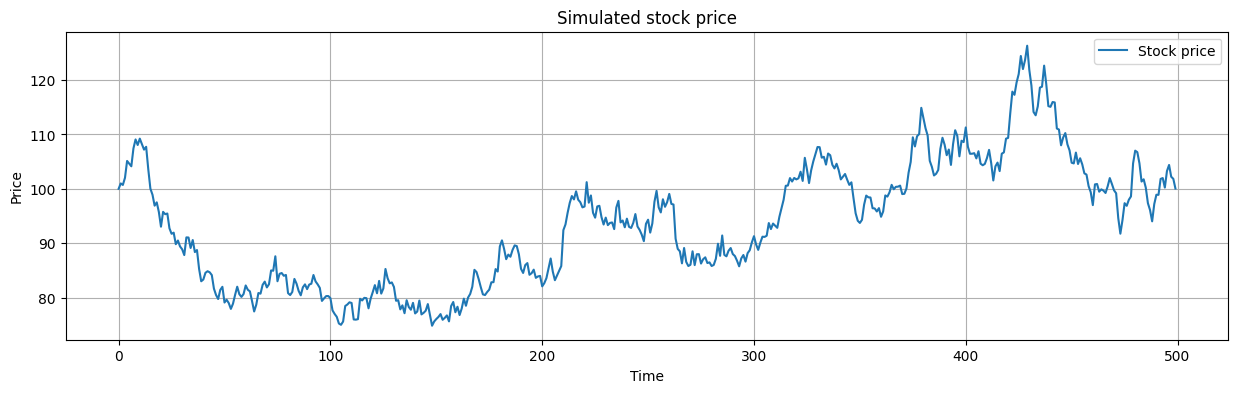

In [3]:
# Simulated stock price data
def generate_stock_prices(days=500):
    np.random.seed(42)
    prices = [100]
    for _ in range(days - 1):
        prices.append(prices[-1] * (1 + np.random.normal(0, 0.02)))
    return np.array(prices)
prices = generate_stock_prices(500)
# Plot cumulative rewards
plt.figure(figsize=(15, 4))
plt.plot(prices, label='Stock price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Simulated stock price')
plt.legend()
plt.grid(True)
plt.show()

# Training

The agent can take 3 decisions: buy, hold or sell. It learns according a $Q$-policy:

Value of an action = its direct reward + discounted value of the optimal action in the next state: $Q(S_t,A_t) = R_t + \gamma \, max_a Q(S_{t+1},a)$

- $\gamma$: Discount factor, present value of future rewards. It discounts the value of future rewards, making rewards received sooner more valuable than those received later
- $\alpha$: Learning rate, speed at which our agent learns
- $\epsilon$: Exploration rate, time proportion where our agent explores new actions instead of exploiting what it has already learnt

In [5]:
# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
actions = ["buy", "hold", "sell"]

# Q-table initialization
q_table = {}

# Market state simplified as we discretize prices into buckets
def get_state(price, prev_price, holdings):
    return (int(price // 5), int(prev_price // 5), holdings)

def choose_action(state):
    if state not in q_table:
        q_table[state] = np.zeros(len(actions))
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(len(actions)))
    return np.argmax(q_table[state])

# We have €1,000 to invest, at start we invest in 0
balance, holdings = 1000, 0
history = []
training_performance = []
train_prices, test_prices = prices[:400], prices[400:]

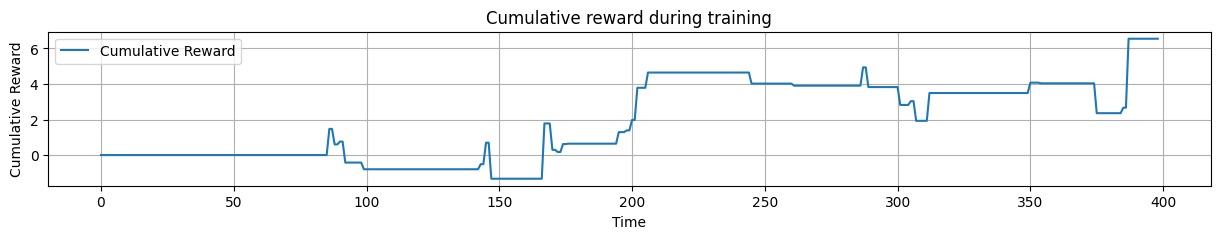

In [6]:
# Initialize variables
rewards = []
cumulative_rewards = []
holdings_records = []

# Training loop
for t in range(len(train_prices) - 1):
    state = get_state(train_prices[t], train_prices[t - 1] if t > 0 else train_prices[t], holdings)
    action = choose_action(state)
    next_price = train_prices[t + 1]

    # Execute action
    reward = 0
    if actions[action] == "buy" and balance >= next_price:
        holdings += 1
        balance -= next_price
    elif actions[action] == "sell" and holdings > 0:
        holdings -= 1
        balance += next_price
        reward = next_price - train_prices[t]  # Profit/Loss

    # Store the reward
    rewards.append(reward)

    next_state = get_state(next_price, train_prices[t], holdings)
    if next_state not in q_table:
        q_table[next_state] = np.zeros(len(actions))

    q_table[state][action] += alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state][action])
    history.append((train_prices[t], holdings, actions[action]))
    holdings_records.append(holdings)

# Calculate cumulative rewards
cumulative_rewards = np.cumsum(rewards)

# Plot cumulative rewards
plt.figure(figsize=(15, 2))
plt.plot(cumulative_rewards, label='Cumulative Reward')
plt.xlabel('Time')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative reward during training')
plt.legend()
plt.grid(True)
plt.show()

Final portfolio value with Q-learning strategy: $948.11
Final portfolio value with buy-and-hold strategy: $899.05


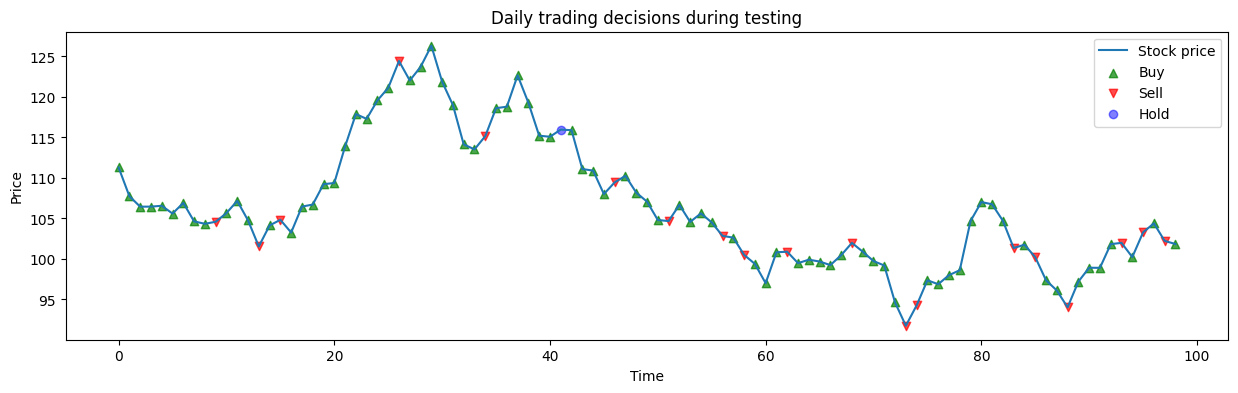

In [7]:
# Test Q-learning agent
initial_balance, balance, holdings = 1000, 1000, 0
test_history = []
for t in range(len(test_prices) - 1):
    state = get_state(test_prices[t], test_prices[t - 1] if t > 0 else test_prices[t], holdings)
    action = choose_action(state)
    next_price = test_prices[t + 1]
    
    if actions[action] == "buy" and balance >= next_price:
        holdings += 1
        balance -= next_price
    elif actions[action] == "sell" and holdings > 0:
        holdings -= 1
        balance += next_price
    
    test_history.append((test_prices[t], holdings, actions[action]))

# Final portfolio value after strategy execution
final_strategy_value = balance + (holdings * test_prices[-1])

# Buy-and-hold strategy performance
initial_stock_holdings = initial_balance / test_prices[0]
final_buy_hold_value = initial_stock_holdings * test_prices[-1]

print(f"Final portfolio value with Q-learning strategy: ${final_strategy_value:.2f}")
print(f"Final portfolio value with buy-and-hold strategy: ${final_buy_hold_value:.2f}")

# Visualization
def plot_results(history, title):
    prices, holdings, actions = zip(*history)
    plt.figure(figsize=(15,4))
    plt.plot(prices, label="Stock price")
    
    buy_points = [i for i in range(len(actions)) if actions[i] == "buy"]
    sell_points = [i for i in range(len(actions)) if actions[i] == "sell"]
    hold_points = [i for i in range(len(actions)) if actions[i] == "hold"]
    
    plt.scatter(buy_points, np.array(prices)[buy_points], marker="^", color="g", label="Buy", alpha=0.7)
    plt.scatter(sell_points, np.array(prices)[sell_points], marker="v", color="r", label="Sell", alpha=0.7)
    plt.scatter(hold_points, np.array(prices)[hold_points], marker="o", color="b", label="Hold", alpha=0.5)
    
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.show()

plot_results(test_history, "Daily trading decisions during testing")